# Deep Learning Assignment A

## Mandatory
The completion and passing of this assignment A is *mandatory* for you passing the course. You will not get any bonus points for any part of this Assignment. 

What you need to do:
Hand in functioning networks. 
Answer all the questions in the notebook consicely and correctly.

You may discuss theory with other groups, but not code nor share code. You may not use ChatGPT4 or similar programs to generate a solution or code.

 <span style="color:red"> Solutions deemed to similar will be run through a program designed to detect coding plagirism and if flagged you will be reported for plagirism. </span> 
 
 One hand in by the group. Works handed in after the deadline will be corrected at my leisure, which may very well be after the summer vacation. Same goes for works that do not pass on the first try and need a second hand-in for the group to pass the course.
 
 If you want to switch groups do so before starting the assignment. **Make sure you are all agreed from the start if you will attempt part B for bonus points or not.**


## Brief
Today you will be working on a blood cell data using an already existing network (transfer learning) to find the important parts of the blood cell and comparing the results to a more advanced model where you incorporate segmentation based on masks made by an expert in the field. 

## Story 
Your boss at BestEverLifeScienceCompany, or BELSC, was quite impressed with your latest work on the white blood cells and wants to pursue that as a potential software feature to sell with the new instrument the lab is developing. During a quick meeting you've tried explaining that if there's a new machine being developed you cannot guarantee that the model you develop now will work on the new data.

Your boss still wants a better proof of concept on the data you do have from the old machine in order to convince the top bosses that this project is worth pursuing and your group should have a 2 day conference to team build with the lab this summer. Your BELSC boss would really like to go before the summer holiday, so your deadline is the 15th of May. 

Since you have explained earlier that determining what's actually important in an image isn't always easy for a neural network, the boss spoke to the lab and you've recieved masks made by experts. Your bosses boss have heard about a couple cool "new" networks, and so you'll have to show results from those networks wether you think they're a good idea or not. 

As you get the data you realise that this data looks nothing like your old data, so you decide to only train on this new dataset. 

Your boss has helpfully added a list of questions that need to be answered by your work in order for the project to be approved.

Summer holidays are right around the corner, and you might go into it with all your work done.
Good luck!


# Tasks and questions


#### Import


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import IPython
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import cv2
import os
from PIL import Image

#VGG16
from keras.applications.vgg16 import VGG16

#ResNet
from tensorflow.keras.applications import ResNet50

#Lab scripts
import plot_helper
import cnn_helper

In [2]:
def start_time():
    print("Starting run at: " + str(datetime.now()))

def end_time():
    print("Run finished at: " + str(datetime.now()))

## T0: unzip your data and load it into your notebook. You do not have to show how you unzip your data in the notebook.

In [3]:
base_directory = "/home/jovyan/big-data_deeplearning/"

## Set up where to find our data
labels_path = base_directory + "Assignments/Class Labels of Dataset 1.csv"
images_path = base_directory + "LabData/bloodcells_seg/images/all/"
masks_path = base_directory + "LabData/bloodcells_seg/masks/all/"
masked_images_path = base_directory + "LabData/bloodcells_seg/masked_images/"

balanced_images_path = base_directory + "LabData/bloodcells_seg/balanced_images/"

df_labels = pd.read_csv(labels_path) 


The names in the 'image ID' column and the filenames do not correspond 1:1. To match this, a small loop is needed to fix the labels in the column. 

In [4]:
for ID in df_labels['image ID']:
    if int(ID) < 10:
        df_labels['image ID'] = df_labels['image ID'].replace([int(ID)], '000' + str(ID) + '.png')
    elif int(ID) < 100:
        df_labels['image ID'] = df_labels['image ID'].replace([int(ID)], '00' + str(ID) + '.png')
    elif int(ID) < 1000:
        df_labels['image ID'] = df_labels['image ID'].replace([int(ID)], '0' + str(ID) + '.png')
        
df_labels

,image ID,class label
0,0001.png,2
1,0002.png,1
2,0003.png,1
3,0004.png,1
4,0005.png,1
...,...,...
295,0296.png,4
296,0297.png,4
297,0298.png,4
298,0299.png,1


Fixing the type of the 'class label' field so that it matches the requeriment (int).

In [5]:
for label in df_labels['class label']:
    df_labels['class label'] = df_labels['class label'].replace([int(label)], str(label))


Remove missrepresented classes

In [6]:
print(df_labels['class label'].value_counts())
df_labels = df_labels[df_labels['class label'] != '5']

print(df_labels['class label'].value_counts())


1    176
2     53
3     48
4     22
5      1
Name: class label, dtype: int64
1    176
2     53
3     48
4     22
Name: class label, dtype: int64


Looking at randomimages from the dataset

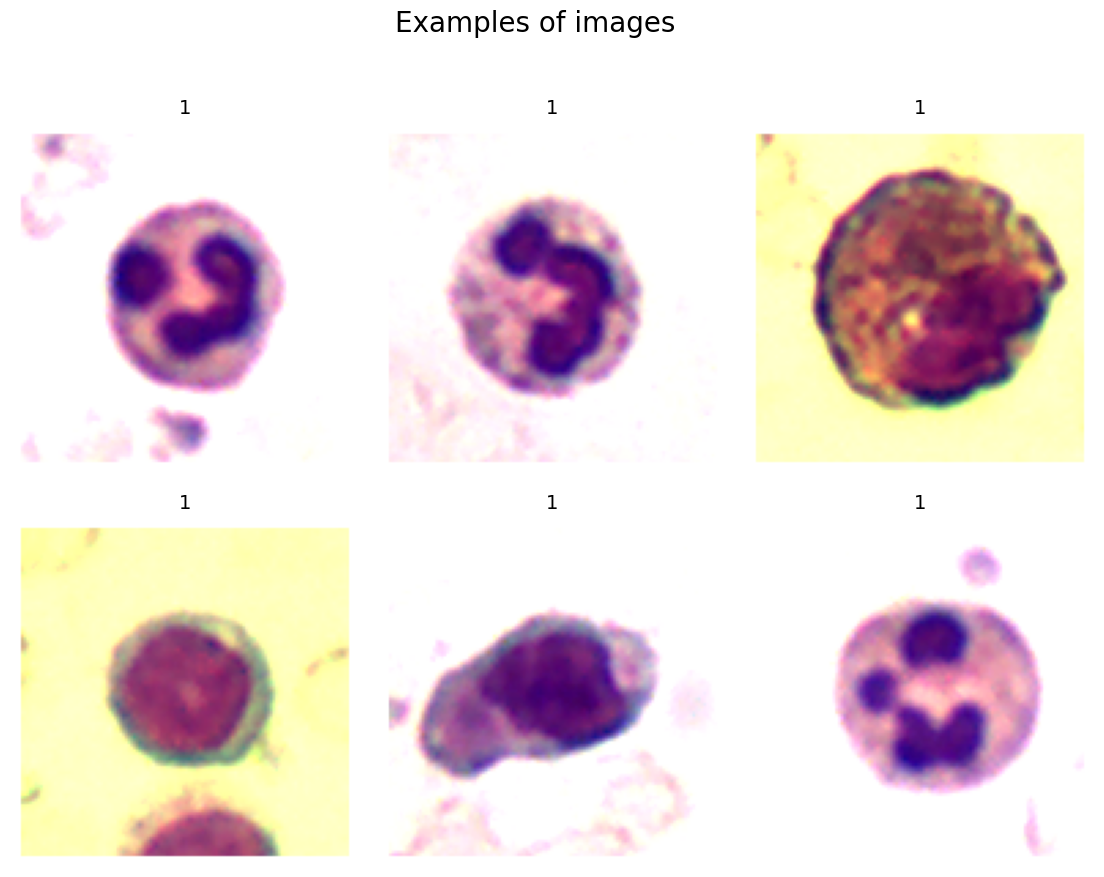

In [7]:
file_column = ["image ID"] ## Enter the name of the file names column
plot_helper.show_random_images(images_path, df_labels, file_column)

In [8]:
## Check the shape of the images:

photo = Image.open(images_path+"0021.png")
array_photo = np.array(photo)
print("Shape of the images is: ", array_photo.shape)
image_shape = array_photo.shape

Shape of the images is:  (128, 128, 3)


#### Divide the images into a train, validation and a test set. 

In [9]:
class_column_header = "class label"
df_labels_to_use = df_labels.copy() # We're copying the df_labels so that you can look at the original again later if you want

test_set_fraction = 0.1
validation_set_fraction = 0.2

df_test = df_labels_to_use.groupby(class_column_header).sample(frac = test_set_fraction)
df_to_use = pd.concat([df_labels_to_use, df_test, df_test]).drop_duplicates(keep=False) 
df_validation = df_labels_to_use.groupby(class_column_header).sample(frac = validation_set_fraction)
df_train = pd.concat([df_labels_to_use, df_validation, df_validation]).drop_duplicates(keep=False) 

In [10]:
print("Number of samples: %d" % len(df_labels_to_use.index))
print("Number of training samples: %d" % len(df_train.index))
print("Number of test samples: %d" % len(df_test.index))
print("Number of validation samples: %d" % len(df_validation.index))

Number of samples: 299
Number of training samples: 239
Number of test samples: 30
Number of validation samples: 60


## T1: Make two neural networks based on only the blood cell images, as they are (i.e. without applying masks), using a VGG and a RESNET (or any other 2 classification networks you like). 



### VGG16

#### Pre-processing & Data generator
For VGG16, we need to call *keras.applications.vgg16.preprocess_input* on your inputs before passing them to the model. 
vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [11]:
## Set up generators for all datasets
batch_size = 17 # maybe it can be changed? 32 is the suggested in Keras documentation.
image_shape = image_shape
filename_column = 'image ID'
true_label_column = "class label"

## Doing the preprocessing required for VGG16.
## The supplied example from Keras documentation is:  train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
## not sure if we should use buffer and cache, or ImageDataGenerator like in the lab.

# preprocessing_function = keras.applications.vgg16.preprocess_input
train_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)


train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=True)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1


Found 239 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.


#### Attempts

In [ ]:
###########################################################################
#                         CNN based on lab 1
###########################################################################
""" 
# Basic CNN network to use as reference point to evaluate our transfer-learning network.
cnn_inputs = keras.Input(shape=image_shape)
x = layers.Conv2D(1, kernel_size=(3, 3), strides=1,padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(4, activation='softmax')(x)
VGG16_model = tf.keras.Model(cnn_inputs, cnn_outputs, name = "VGG16_model")
"""

In [ ]:
###########################################################################
#                         VGG16 based on lab 2
###########################################################################
"""

## Instantiate the base model [VGG16]
#VGG16_base_model = VGG16(weights = 'imagenet', input_shape = image_shape, include_top = False) 
vgg_model = keras.applications.VGG16(include_top=False, weights=None, input_shape=image_shape,pooling=None,)

# add new classifier layers
flat1 = layers.Flatten()(vgg_model.layers[-1].output) 
class1 = layers.Dense(1024, activation='relu')(flat1)
output = layers.Dense(4, activation='softmax')(class1)

# Ensamble the new full network
vgg_model = keras.Model(inputs=vgg_model.inputs, outputs=output)
print (vgg_model.summary())

## Compile the model
vgg_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', 
                  metrics = [keras.metrics.CategoricalAccuracy()])

## Actually train model
epochs = 10
history = vgg_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs)

## Test the model on the test data
result = vgg_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(history, "VGG16")
print("\n")

## Confussion Matrix
cnn_helper.plot_confusion_matrix_from_generator(vgg_model, valid_generator)
"""

In [ ]:
## Add our own model on top of the base_model
################################################### BASE MODEL FROM KERAS DOCUMENTATION

#inputs = keras.Input(shape=(128, 128, 3))
#x = VGG16_base_model(inputs, training=False)  # set to inference mode
#x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(1024, activation='relu')(x)
#outputs = keras.layers.Dense(4, activation='softmax')(x) # we only have 4 classes, since one was under-represented and elminated.

#VGG16_model = keras.Model(inputs=inputs, outputs=outputs, name="VGG16_model")

#VGG16_model.summary()

#### The typical transfer-learning workflow
The typical transfer learning workflow that can be implemented in Keras, and that we will follow is:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.

In [12]:
## Instantiate the base model [VGG16], with pre-trained weights from the ImageNet dataset.
## We remove the top Fully-Connected Layers, since we will train these on our own dataset.
## We use the shape for our dataset (128, 128, 3), that we checked with a script.
VGG16_base_model = VGG16(weights = 'imagenet', input_shape = image_shape, include_top = False, pooling=None,) 

## Freeze the base model, so that we don't modify the weights when backpropagating
VGG16_base_model.trainable = False

# Our top layers, and the model that we will train.
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output) # could be GlobalAveragePooling2D, GlobalMaxPooling2D or Flatten as well, not sure how to pick
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)  # To reduce overfittin, since in the plots we are getting a lot.
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dense(4, activation = 'softmax')(x)

# Ensamble the new full network
VGG16_model = tf.keras.Model(VGG16_base_model.input, x, name = "VGG16_model")

#VGG16_model.summary()

## Compile the new model, using the base model + the new layers that we added
VGG16_model.compile(optimizer = keras.optimizers.Adam(), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = [keras.metrics.CategoricalAccuracy()])

## Actually train model
start_time()
epochs = 20
VGG16_history = VGG16_model.fit(train_generator,
                    steps_per_epoch = train_steps,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1)
end_time()

Starting run at: 2023-05-18 12:44:18.629450
Epoch 1/20
14/14 [==============================] - 4s 92ms/step - loss: 12.4329 - categorical_accuracy: 0.4775 - val_loss: 3.2188 - val_categorical_accuracy: 0.6078
Epoch 2/20
14/14 [==============================] - 1s 44ms/step - loss: 10.0014 - categorical_accuracy: 0.4595 - val_loss: 4.3472 - val_categorical_accuracy: 0.4510
Epoch 3/20
14/14 [==============================] - 1s 41ms/step - loss: 5.9276 - categorical_accuracy: 0.5135 - val_loss: 5.2909 - val_categorical_accuracy: 0.5490
Epoch 4/20
14/14 [==============================] - 1s 41ms/step - loss: 4.5252 - categorical_accuracy: 0.6036 - val_loss: 6.6944 - val_categorical_accuracy: 0.2353
Epoch 5/20
14/14 [==============================] - 1s 39ms/step - loss: 5.4748 - categorical_accuracy: 0.5450 - val_loss: 4.0583 - val_categorical_accuracy: 0.3922
Epoch 6/20
14/14 [==============================] - 1s 41ms/step - loss: 3.8693 - categorical_accuracy: 0.5901 - val_loss: 2.8236

#### Test and evaluation of the model
Test the  model agains the test data, plot performance curves and confusion matrix

2/2 [==============================] - 0s 261ms/step - loss: 1.2702 - categorical_accuracy: 0.7667
Test Loss:  1.270218014717102
Test Accuracy:  0.7666666507720947




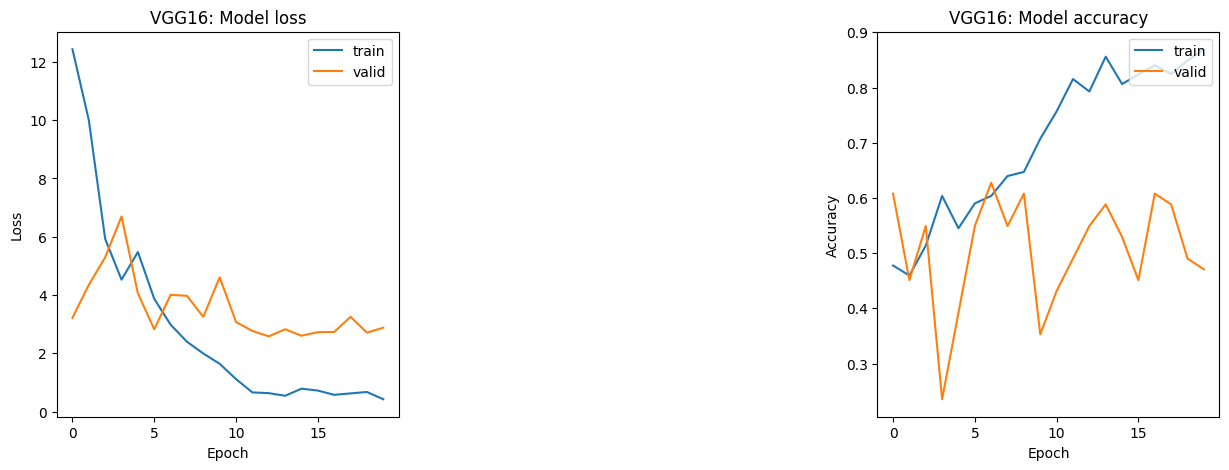



Accuracy on the validation dataset: 0.7666666666666667


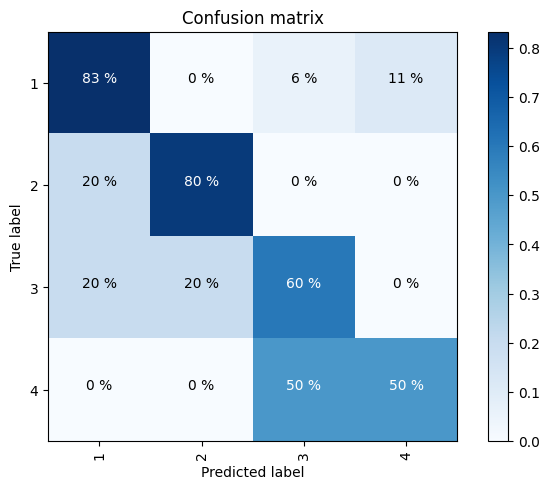

In [13]:
## Test the model on the test data
result = VGG16_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(VGG16_history, "VGG16")
print("\n")

## Confussion Matrix
cnn_helper.plot_confusion_matrix_from_generator(VGG16_model, test_generator)

### RESNET:

Classify classes with ResNet50 https://keras.io/api/applications/resnet/

#### Pre-processing & Data generator
For VGG16, we need to call *keras.applications.vgg16.preprocess_input* on your inputs before passing them to the model. 
vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [14]:
## Set up generators for all datasets
batch_size = 17 # maybe it can be changed? 32 is the suggested in Keras documentation.
image_shape = image_shape
filename_column = 'image ID'
true_label_column = "class label"

## Doing the preprocessing required for VGG16.
## The supplied example from Keras documentation is:  train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
## not sure if we should use buffer and cache, or ImageDataGenerator like in the lab.

# preprocessing_function = keras.applications.vgg16.preprocess_input
train_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input)


train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=True)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1


Found 239 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.


#### Transfer-learning workflow

In [15]:
## Instantiate the base model
ResNet_base_model = ResNet50(weights = "imagenet", input_shape = image_shape, include_top = False)

## Freeze the base model,
ResNet_base_model.trainable = False

## Create new model on top - basic formulation from keras documentation
last_layer = ResNet_base_model.get_layer('conv5_block3_out')
last_output = last_layer.output

x = keras.layers.GlobalAveragePooling2D()(last_output)
x = keras.layers.Dense(512, activation = 'relu')(x)  # It realy improves the accurcy of the network
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
outputs = keras.layers.Dense(4)(x)

# Ensamble the new full network
ResNet_model = keras.Model(ResNet_base_model.input, outputs, name = "ResNet_model")
#ResNet_model.summary()

## Compile the new model, using the base model + the new layers that we added
ResNet_model.compile(optimizer = keras.optimizers.Adam(), 
                    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics = [keras.metrics.CategoricalAccuracy()])

## Actually train model
start_time()
epochs = 20

ResNet_history = ResNet_model.fit(train_generator,
                    steps_per_epoch = train_steps,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1)

end_time()

Starting run at: 2023-05-18 12:45:24.224307
Epoch 1/20
14/14 [==============================] - 5s 134ms/step - loss: 2.0271 - categorical_accuracy: 0.4160 - val_loss: 1.4691 - val_categorical_accuracy: 0.6863
Epoch 2/20
14/14 [==============================] - 1s 52ms/step - loss: 1.4184 - categorical_accuracy: 0.4685 - val_loss: 1.1787 - val_categorical_accuracy: 0.6471
Epoch 3/20
14/14 [==============================] - 1s 44ms/step - loss: 1.1355 - categorical_accuracy: 0.5336 - val_loss: 1.2385 - val_categorical_accuracy: 0.3529
Epoch 4/20
14/14 [==============================] - 1s 45ms/step - loss: 1.0572 - categorical_accuracy: 0.5946 - val_loss: 1.2602 - val_categorical_accuracy: 0.6863
Epoch 5/20
14/14 [==============================] - 1s 43ms/step - loss: 0.8467 - categorical_accuracy: 0.6261 - val_loss: 1.1145 - val_categorical_accuracy: 0.6863
Epoch 6/20
14/14 [==============================] - 1s 46ms/step - loss: 0.7751 - categorical_accuracy: 0.6802 - val_loss: 1.1296 

#### Test and evaluation of the model
Test the  model agains the test data, plot performance curves and confusion matrix

2/2 [==============================] - 0s 138ms/step - loss: 0.9466 - categorical_accuracy: 0.7667
Test Loss:  0.9465817809104919
Test Accuracy:  0.7666666507720947




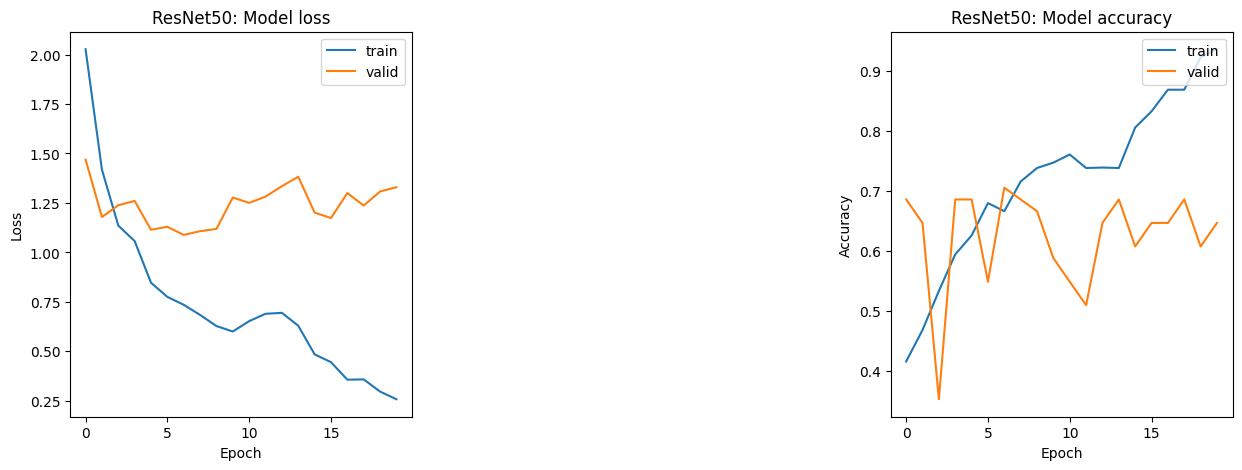

Accuracy on the validation dataset: 0.7666666666666667


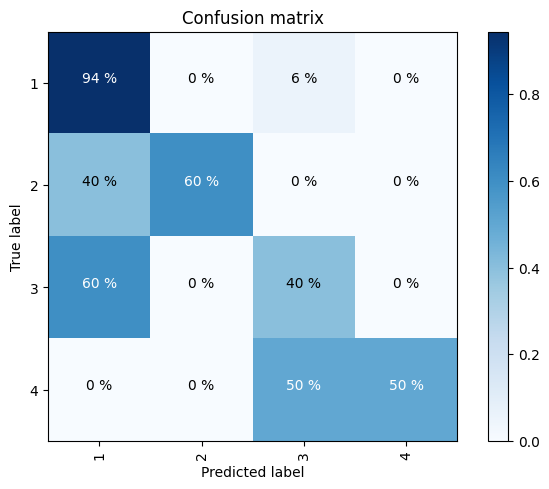

In [16]:
## Test the model on the test data
result = ResNet_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(ResNet_history, "ResNet50")

## Confussion Matrix
cnn_helper.plot_confusion_matrix_from_generator(ResNet_model, test_generator)

### Q1: Which network performs the best?  
After running both networks with similar architectures build upon the already existing network using transfer learning on VGG16 and ResNet50, with the following parameters:
* 20 epochs (we tried to run it for 30 but it seems to overfit the data too much)
* Using the same batch size (we are using 17, since it seems to be the general agreement that the ideal batch size is the square root of the size of the dataset, and since we have a dataset of 299 samples, the batch size should be 17).

We get the following results:
1. VGG16:
  - Accuracy on the test dataset: *0.833*
  - Loss on the test dataset: *1.8709*

2. ResNet50:
  - Accuracy on the test dataset: *0.8*
  - Loss on the test dataset: *0.596*
  
These results are fairly equal, but when looking at the loss plot and accuracy plot for the validation dataset, we can see that the VGG16 seems to perform better. Both perform fairly equal, so we don't think it can be said that one is considerably better than the other one in our case.

We also ran the dataset through a basic CNN network (without using any pre-trained model), and the VGG16 supplied in Lab2, and got similar (but worse) results, making us assume that our networks are performing as expected and that we should use other tools to improve the results.

## T2: Try the same networks with the mask applied to the training and validation datasets.   
Hint: If you like you can create a third "folder" where you've manually added a 4th mask layer to your images, or you can do this in a preproccessing step.   
Optional: If you do not get this to work in 2 hours, write a minimum 3 paragraph discussion on segmentation and it's uses to improve classification in this case. Make sure to use references. 

### Image Masker
Image masker to add the mask to each image, and save it in a new folder.

In [17]:
## Adding the masks to the images. We have to skip the preprocessing for vgg16 since it only accepts 3 channels as input
for image in os.listdir(images_path):
    if image.endswith('.png'):
        image_path = os.path.join(images_path, image)
        mask_path = os.path.join(masks_path, image)
        image_np = np.array(Image.open(image_path).convert('RGBA'))
        mask_np = np.array(Image.open(mask_path).convert('L'))
        
        # we add the mask
        for lvl in range(3):
            image_np[:, :, lvl] = image_np[:, :, lvl] * mask_np
        masked_image = Image.fromarray(image_np)
        # we saved the masked image
        masked_image.save(os.path.join(masked_images_path, image))
        
        

### VGG with masks:

Found 239 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.
Starting run at: 2023-05-18 12:46:33.452777
Epoch 1/40
14/14 [==============================] - 2s 92ms/step - loss: 20.2730 - categorical_accuracy: 0.3901 - val_loss: 14.4021 - val_categorical_accuracy: 0.4792
Epoch 2/40
14/14 [==============================] - 1s 42ms/step - loss: 15.9580 - categorical_accuracy: 0.4619 - val_loss: 15.2525 - val_categorical_accuracy: 0.2708
Epoch 3/40
14/14 [==============================] - 1s 35ms/step - loss: 10.7142 - categorical_accuracy: 0.4888 - val_loss: 10.6913 - val_categorical_accuracy: 0.1042
Epoch 4/40
14/14 [==============================] - 0s 33ms/step - loss: 7.2778 - categorical_accuracy: 0.4888 - val_loss: 9.5853 - val_categorical_accuracy: 0.1250
Epoch 5/40
14/14 [==============================] - 1s 35ms/step - loss: 6.4712 - categorical_accuracy: 0.5067 -

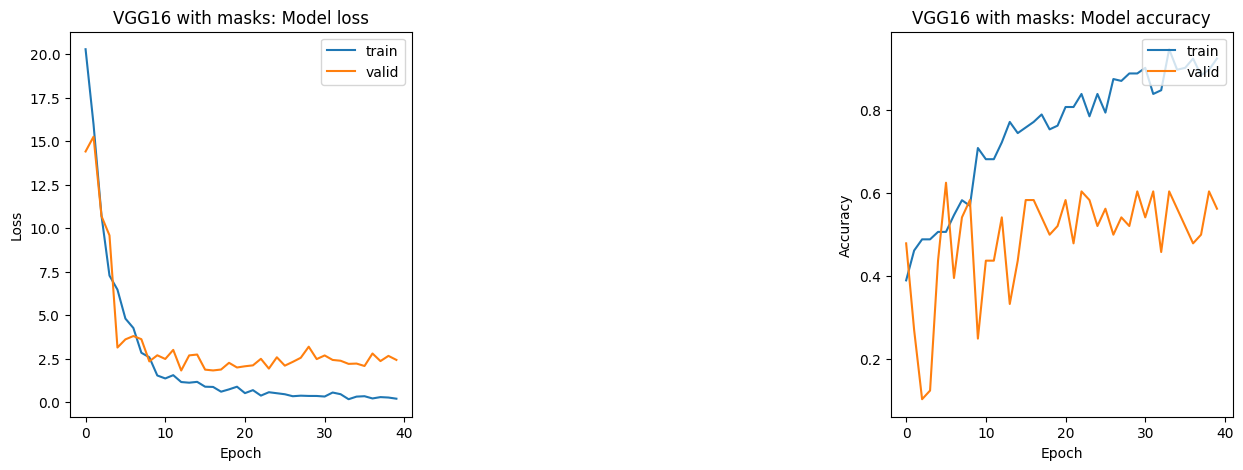



Accuracy on the validation dataset: 0.4666666666666667


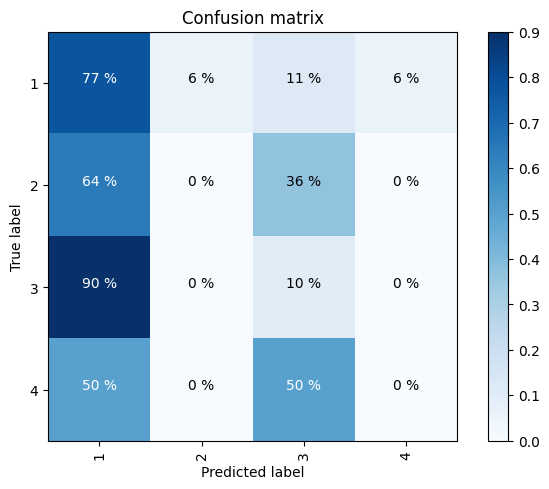

In [18]:
#################################################################
#                      Data generator
#################################################################
## Set up generators for all datasets
batch_size = 16 # maybe it can be changed? 32 is the suggested in Keras documentation.
image_shape = (128, 128, 3) # we need to add an extra channel for the mask
filename_column = 'image ID'
true_label_column = "class label"

## Data generator
train_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)


train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=masked_images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=True)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=masked_images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1





#################################################################
#                      VGG16 model
#################################################################
## Not sure if the way that we proceeded is the intended, but since VGG16 can only intake images with 3 channels, we tried to
## process the mask in paralel.

VGG16_base_model = VGG16(weights = 'imagenet', input_shape = (128, 128, 3), include_top = False, pooling=None,)

## Freeze the base model, so that we don't modify the weights when backpropagating
VGG16_base_model.trainable = False

# Our top layers, and the model that we will train.
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output) # could be GlobalAveragePooling2D, GlobalMaxPooling2D or Flatten as well, not sure how to pick
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)  # To reduce overfittin, since in the plots we are getting a lot.
x = keras.layers.Dense(256, activation = 'relu')(x)
x = keras.layers.Dense(4, activation = 'softmax')(x)

# Ensamble the new full network
VGG16_model = tf.keras.Model(VGG16_base_model.input, x, name = "VGG16_model")

#VGG16_model.summary()

## Compile the new model, using the base model + the new layers that we added
VGG16_model.compile(optimizer = keras.optimizers.Adam(), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = [keras.metrics.CategoricalAccuracy()])

## Actually train model
start_time()
epochs = 40
VGG16_history = VGG16_model.fit(train_generator,
                    steps_per_epoch = train_steps,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1)
end_time()





#################################################################
#                      Test and evaluation
#################################################################
## Test the model on the test data
result = VGG16_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(VGG16_history, "VGG16 with masks")
print("\n")

## Confussion Matrix
cnn_helper.plot_confusion_matrix_from_generator(VGG16_model, valid_generator)

### RESNET with masks:

Found 239 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.
Starting run at: 2023-05-18 12:47:02.058503
Epoch 1/40
14/14 [==============================] - 5s 121ms/step - loss: 3.8252 - categorical_accuracy: 0.3874 - val_loss: 1.3492 - val_categorical_accuracy: 0.6667
Epoch 2/40
14/14 [==============================] - 1s 39ms/step - loss: 2.6013 - categorical_accuracy: 0.4640 - val_loss: 2.5060 - val_categorical_accuracy: 0.6863
Epoch 3/40
14/14 [==============================] - 1s 39ms/step - loss: 2.4428 - categorical_accuracy: 0.4459 - val_loss: 1.6751 - val_categorical_accuracy: 0.6863
Epoch 4/40
14/14 [==============================] - 1s 41ms/step - loss: 1.5156 - categorical_accuracy: 0.5270 - val_loss: 1.0299 - val_categorical_accuracy: 0.6471
Epoch 5/40
14/14 [==============================] - 1s 42ms/step - loss: 1.2102 - categorical_accuracy: 0.5856 - val_

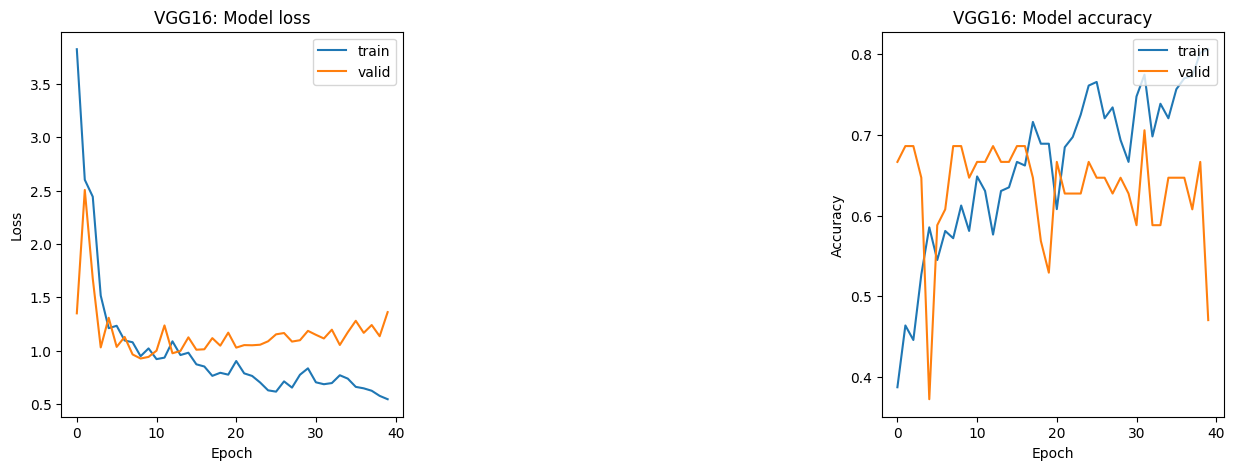



Accuracy on the validation dataset: 0.45


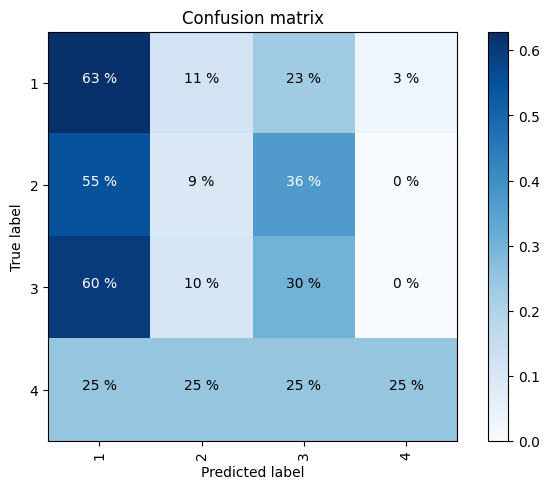

In [19]:
#################################################################
#                      Data generator
#################################################################
## Set up generators for all datasets
batch_size = 17 # maybe it can be changed? 32 is the suggested in Keras documentation.
image_shape = image_shape
filename_column = 'image ID'
true_label_column = "class label"

## Doing the preprocessing required for VGG16.
## The supplied example from Keras documentation is:  train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
## not sure if we should use buffer and cache, or ImageDataGenerator like in the lab.

# preprocessing_function = keras.applications.vgg16.preprocess_input
train_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input)


train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=masked_images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=True)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=masked_images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1





#################################################################
#                      ResNet50 model
#################################################################
## Instantiate the base model
ResNet_base_model = ResNet50(weights = "imagenet", input_shape = image_shape, include_top = False)

## Freeze the base model,
ResNet_base_model.trainable = False

## Create new model on top - basic formulation from keras documentation
last_layer = ResNet_base_model.get_layer('conv5_block3_out')
last_output = last_layer.output

x = keras.layers.GlobalAveragePooling2D()(last_output)
x = keras.layers.Dense(512, activation = 'relu')(x)  # It realy improves the accurcy of the network
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
outputs = keras.layers.Dense(4)(x)

# Ensamble the new full network
ResNet_model = keras.Model(ResNet_base_model.input, outputs, name = "ResNet_model")
#ResNet_model.summary()

## Compile the new model, using the base model + the new layers that we added
ResNet_model.compile(optimizer = keras.optimizers.Adam(), 
                    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics = [keras.metrics.CategoricalAccuracy()])

## Actually train model
start_time()
epochs = 40

ResNet_history = ResNet_model.fit(train_generator,
                    steps_per_epoch = train_steps,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1)
end_time()





#################################################################
#                      Test and evaluation
#################################################################
## Test the model on the test data
result = ResNet_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(ResNet_history, "VGG16")
print("\n")

## Confussion Matrix
cnn_helper.plot_confusion_matrix_from_generator(ResNet_model, valid_generator)

### Q2: Did you get better results with or without the mask?   
When using the masks, we can observe an improvement in the tendencies displayed by the plots. Therefore, we can deduce that the model is performing better whit the training and validation datasets.
On the other hand, it seems to perform poorly on the test dataset. This might be caused by using the masked images for train and validation, but not for test, which would require a higher degree of abstraction from the model to be able to perform as well in the test data as it does on the validation.

### Q3: Did the same network perform better in T1 as in T2? Why? 
The answer would be the same in this case, both networks perform better on the train and validation datasets when dealing with the masked images, but worse with the test data. On the other hand, in T1, when dealing with regular images, both networks perform better on the train and test datasets. This seems odd to us, but after many attempts of adjusting different parameters, searching for new ways to apply the masks, and even trying to modify the architecture used (adding some extra layers, or altering the amount of neurons in each layer) we didn't manage to obtain any better result.

## T3: Try improving your best network even further in atleast 3 ways to see if you get better result. 

1. Data augmentation to improve the dataset: 
Could be done with or without masking. Since we are not sure how to handle masking when data augmenting, we decided to proceed witht he regular images.
2. Early Stopping
3. Regularization

### Data Augmentation
Since the dataset that we are working with is significantly small and very unbalanced (only 299 samples, and 50% correspond to only one class), the first and probably most effective way to improve our networks, is using data augmentation to improve the quality of our dataset.

In [20]:
#################################################################
#              Balancing the Dataset
#################################################################
## To balance the dataset, we apply data augmentation using random sampling.

## we only want to do data augmentation on the training data.
df_train_balanced = df_train.copy()

# Calculate the weight of each class in the train dataset.
weights = df_train_balanced['class label'].value_counts()
desired_samples_per_class = 230  # shouldn't be bigger than 234, or the names are going to crash
print(weights)

## ImageDataGenerator for data augmentation
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range = 90,
                                                                   width_shift_range = 0.05,
                                                                   height_shift_range = 0.05,
                                                                   shear_range = 0.1,
                                                                   zoom_range = 0.1,
                                                                   horizontal_flip=True,
                                                                   vertical_flip=True,
                                                                   brightness_range = [0.8,1.2])

## Iterate to create new images from the existing ones until the dataset is balanced.
last_name = 300
for class_label in weights.index:
    samples_in_class = len(df_train_balanced[df_train_balanced['class label'] == class_label])
    
    while samples_in_class < desired_samples_per_class:
        last_name += 1
        ## We load the images to augmentate from the normal direcotry, since we only want to augmentate original images.
        ran_image_from_class_name = df_train[df_train['class label'] == class_label].sample(1)
        image = Image.open(images_path+str(ran_image_from_class_name.iloc[0]['image ID']))
        array_image = np.array(image)
        
        ## create the new randomly modiffied image usgin the data augmentation defined.
        array_image = np.expand_dims(array_image, 0) # we need to turn the image from matrix to tensor, otherwise the flow crashes.
        batch = train_data_generator.flow(array_image, batch_size = 1).next()
        new_image = batch[0].astype('uint8')
        
        ## save the image with the new name and add it to the dataframe of training data.
        new_image_name = "0" + str(last_name) + ".png"
        keras.preprocessing.image.save_img(balanced_images_path + new_image_name, new_image)
        df_train_balanced = pd.concat([df_train_balanced, pd.DataFrame({'image ID': [new_image_name], 'class label': [class_label]})])
        
        samples_in_class += 1

print(df_train_balanced['class label'].value_counts())


1    141
2     42
3     38
4     18
Name: class label, dtype: int64
1    230
2    230
3    230
4    230
Name: class label, dtype: int64


Found 919 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image ID". These filename(s) will be ignored.
  warnings.warn(


Starting run at: 2023-05-18 12:49:22.510408
Epoch 1/40
14/14 [==============================] - 5s 237ms/step - loss: 13.2529 - categorical_accuracy: 0.3029 - val_loss: 4.8442 - val_categorical_accuracy: 0.5167
Epoch 2/40
14/14 [==============================] - 2s 116ms/step - loss: 6.0259 - categorical_accuracy: 0.3930 - val_loss: 2.6290 - val_categorical_accuracy: 0.4000
Epoch 3/40
14/14 [==============================] - 1s 101ms/step - loss: 3.7693 - categorical_accuracy: 0.4678 - val_loss: 2.3582 - val_categorical_accuracy: 0.4667
Epoch 4/40
14/14 [==============================] - 2s 104ms/step - loss: 2.8353 - categorical_accuracy: 0.4749 - val_loss: 1.9410 - val_categorical_accuracy: 0.4833
Epoch 5/40
14/14 [==============================] - 2s 105ms/step - loss: 2.0266 - categorical_accuracy: 0.5357 - val_loss: 1.8483 - val_categorical_accuracy: 0.3500
Epoch 6/40
14/14 [==============================] - 2s 108ms/step - loss: 1.6830 - categorical_accuracy: 0.5708 - val_loss: 1

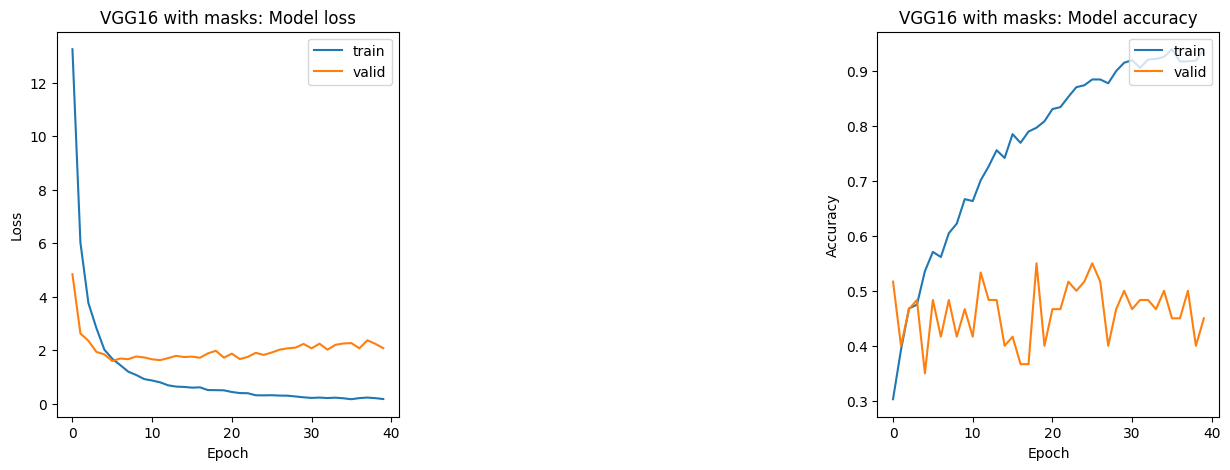



Accuracy on the validation dataset: 0.7666666666666667


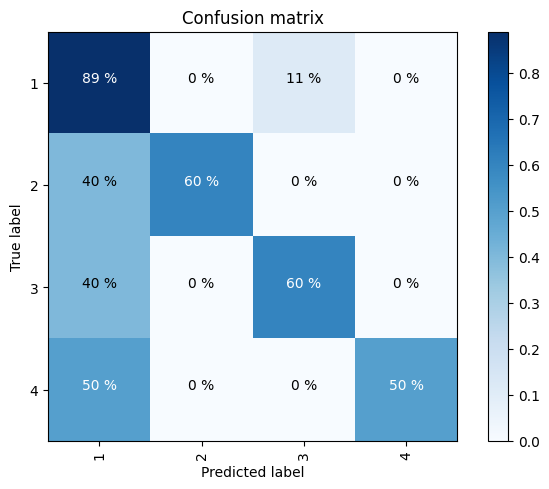

In [21]:
#################################################################
#                      Data generator
#################################################################
## Set up generators for all datasets
batch_size = 64 
image_shape = (128, 128, 3) # we need to add an extra channel for the mask
filename_column = 'image ID'
true_label_column = "class label"

## Data generator with data augmentation preprocessing for the training data
train_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)

## NOT SURE IF WITH THIS DATA AUGMENTATION, THE DATASET IS STILL UNBALANCED, OR IF THAT GETS FIXED.

train_generator = train_data_generator.flow_from_dataframe(
    df_train_balanced, directory=balanced_images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=True)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1





#################################################################
#                      VGG16 model
#################################################################
## Not sure if the way that we proceeded is the intended, but since VGG16 can only intake images with 3 channels, we tried to
## process the mask in paralel.

VGG16_base_model = VGG16(weights = 'imagenet', input_shape = (128, 128, 3), include_top = False, pooling=None,)

## Freeze the base model, so that we don't modify the weights when backpropagating
VGG16_base_model.trainable = False

# Our top layers, and the model that we will train.
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output) # could be GlobalAveragePooling2D, GlobalMaxPooling2D or Flatten as well, not sure how to pick
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)  # To reduce overfittin, since in the plots we are getting a lot.
x = keras.layers.Dense(256, activation = 'relu')(x)
x = keras.layers.Dense(4, activation = 'softmax')(x)

# Ensamble the new full network
VGG16_model = tf.keras.Model(VGG16_base_model.input, x, name = "VGG16_model")

#VGG16_model.summary()

## Compile the new model, using the base model + the new layers that we added
VGG16_model.compile(optimizer = keras.optimizers.Adam(), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = [keras.metrics.CategoricalAccuracy()])

## Actually train model
start_time()
epochs = 40
VGG16_history = VGG16_model.fit(train_generator,
                    steps_per_epoch = train_steps,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1)
end_time()





#################################################################
#                      Test and evaluation
#################################################################
## Test the model on the test data
result = VGG16_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(VGG16_history, "VGG16 with masks")
print("\n")

## Confussion Matrix
cnn_helper.plot_confusion_matrix_from_generator(VGG16_model, test_generator)

### Early stopping and Best model storage
Even after balancing the data with data augmentation, we still seem to be suffering a lot of overfitting, so we will try early stopping. We also added a checkpoint so that the model that acomplishes the lower loss on the validation dataset gets saved.

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image ID". These filename(s) will be ignored.
  warnings.warn(


Found 919 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.
Starting run at: 2023-05-18 12:50:31.535480
Epoch 1/100
14/14 [==============================] - 4s 204ms/step - loss: 16.3093 - categorical_accuracy: 0.3345 - val_loss: 3.9768 - val_categorical_accuracy: 0.4667
Epoch 2/100
14/14 [==============================] - 2s 176ms/step - loss: 5.2513 - categorical_accuracy: 0.3778 - val_loss: 2.6865 - val_categorical_accuracy: 0.4167
Epoch 3/100
14/14 [==============================] - 2s 124ms/step - loss: 2.7871 - categorical_accuracy: 0.4585 - val_loss: 2.3268 - val_categorical_accuracy: 0.4000
Epoch 4/100
14/14 [==============================] - 2s 167ms/step - loss: 1.8056 - categorical_accuracy: 0.5228 - val_loss: 1.7941 - val_categorical_accuracy: 0.3667
Epoch 5/100
14/14 [==============================] - 2s 150ms/step - loss: 1.4077 - categorical_accuracy: 0.5

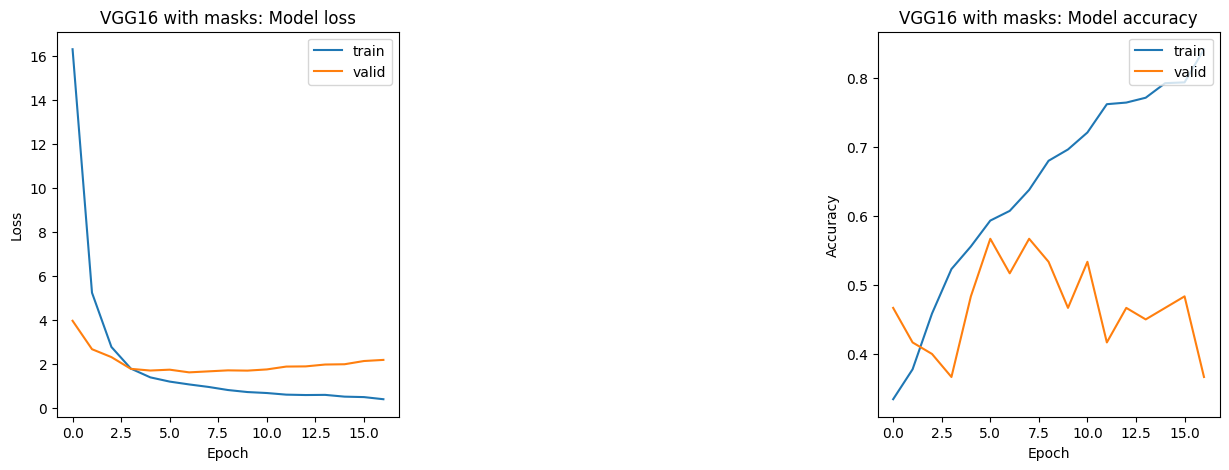



Accuracy on the validation dataset: 0.7666666666666667


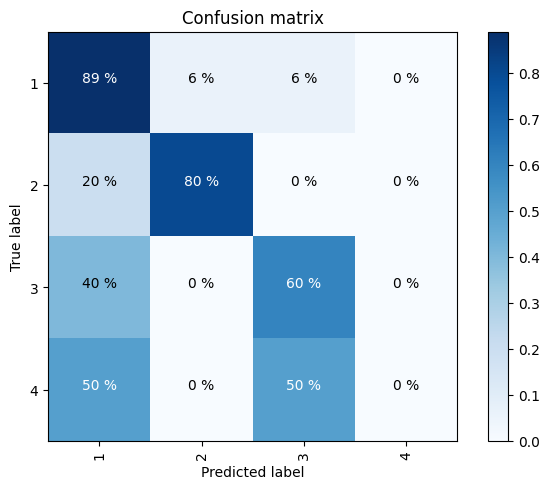

In [22]:
#################################################################
#                      Data generator
#################################################################
## Set up generators for all datasets
batch_size = 64 
image_shape = (128, 128, 3) # we need to add an extra channel for the mask
filename_column = 'image ID'
true_label_column = "class label"

## Data generator with data augmentation preprocessing for the training data
train_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)

## NOT SURE IF WITH THIS DATA AUGMENTATION, THE DATASET IS STILL UNBALANCED, OR IF THAT GETS FIXED.

train_generator = train_data_generator.flow_from_dataframe(
    df_train_balanced, directory=balanced_images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=True)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1





#################################################################
#                      VGG16 model
#################################################################
## Not sure if the way that we proceeded is the intended, but since VGG16 can only intake images with 3 channels, we tried to
## process the mask in paralel.

VGG16_base_model = VGG16(weights = 'imagenet', input_shape = (128, 128, 3), include_top = False, pooling=None,)

## Freeze the base model, so that we don't modify the weights when backpropagating
VGG16_base_model.trainable = False

# Our top layers, and the model that we will train.
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output) # could be GlobalAveragePooling2D, GlobalMaxPooling2D or Flatten as well, not sure how to pick
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)  # To reduce overfittin, since in the plots we are getting a lot.
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dense(4, activation = 'softmax')(x)

# Ensamble the new full network
VGG16_model = tf.keras.Model(VGG16_base_model.input, x, name = "VGG16_model")

#VGG16_model.summary()

## Compile the new model, using the base model + the new layers that we added
VGG16_model.compile(optimizer = keras.optimizers.Adam(), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = [keras.metrics.CategoricalAccuracy()])

## Early Stopping and saving the best model that we get during training
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
save_best_model = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

## Actually train model
start_time()
epochs = 100
VGG16_history = VGG16_model.fit(train_generator,
                    steps_per_epoch = train_steps,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    callbacks = [early_stop, save_best_model])
end_time()

best_model = keras.models.load_model('best_model.h5')



#################################################################
#                      Test and evaluation
#################################################################
## Test the model on the test data
result = best_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(VGG16_history, "VGG16 with masks")
print("\n")

## Confussion Matrix
cnn_helper.plot_confusion_matrix_from_generator(best_model, test_generator)


### Regularitzation to avoid overfitting 
Even after balancing the data with data augmentation, we still seem to be suffering a lot of overfitting, so we will try early stopping. We also added a checkpoint so that the model that acomplishes the lower loss on the validation dataset gets saved.

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image ID". These filename(s) will be ignored.
  warnings.warn(


Found 919 validated image filenames belonging to 4 classes.
Found 60 validated image filenames belonging to 4 classes.
Found 30 validated image filenames belonging to 4 classes.
Starting run at: 2023-05-18 12:51:05.653869
Epoch 1/100
3/3 [==============================] - 7s 768ms/step - loss: 41.6983 - categorical_accuracy: 0.2539 - val_loss: 29.0278 - val_categorical_accuracy: 0.5833
Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 37.0983 - categorical_accuracy: 0.3167 - val_loss: 18.0436 - val_categorical_accuracy: 0.2167
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 18.6554 - categorical_accuracy: 0.3698 - val_loss: 16.8931 - val_categorical_accuracy: 0.1333
Epoch 4/100
3/3 [==============================] - 2s 770ms/step - loss: 19.8507 - categorical_accuracy: 0.3346 - val_loss: 13.5286 - val_categorical_accuracy: 0.3833
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 14.2453 - categorical_accuracy: 0.3841 - val_l

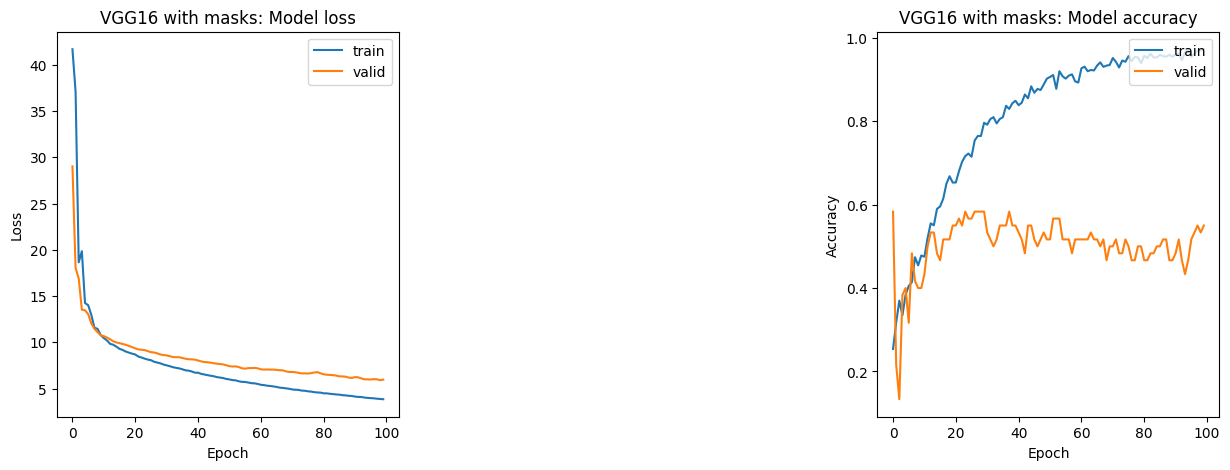



Accuracy on the validation dataset: 0.8


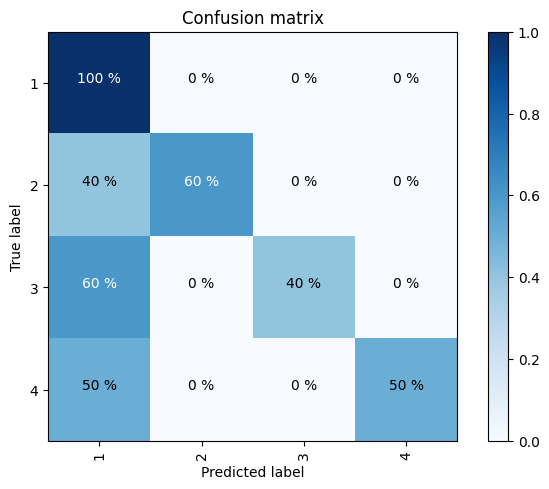

In [23]:
#################################################################
#                      Data generator
#################################################################
## Set up generators for all datasets
batch_size = 256 
image_shape = (128, 128, 3) # we need to add an extra channel for the mask
filename_column = 'image ID'
true_label_column = "class label"

## Data generator with data augmentation preprocessing for the training data
train_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)

## NOT SURE IF WITH THIS DATA AUGMENTATION, THE DATASET IS STILL UNBALANCED, OR IF THAT GETS FIXED.

train_generator = train_data_generator.flow_from_dataframe(
    df_train_balanced, directory=balanced_images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=True)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=images_path, x_col=filename_column, y_col=true_label_column,
    class_mode='categorical', batch_size=batch_size, target_size = image_shape[:2], color_mode='rgb', shuffle=False)


train_steps = train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps = valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1





#################################################################
#                      VGG16 model
#################################################################
## Not sure if the way that we proceeded is the intended, but since VGG16 can only intake images with 3 channels, we tried to
## process the mask in paralel.

VGG16_base_model = VGG16(weights = 'imagenet', input_shape = (128, 128, 3), include_top = False, pooling=None,)

## Freeze the base model, so that we don't modify the weights when backpropagating
VGG16_base_model.trainable = False

# Our top layers, and the model that we will train.
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output) # could be GlobalAveragePooling2D, GlobalMaxPooling2D or Flatten as well, not sure how to pick
x = keras.layers.Dense(512, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)  # To reduce overfittin, since in the plots we are getting a lot.
x = keras.layers.Dense(512, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(x)
x = keras.layers.Dense(4, activation = 'softmax')(x)

# Ensamble the new full network
VGG16_model = tf.keras.Model(VGG16_base_model.input, x, name = "VGG16_model")

#VGG16_model.summary()

## Compile the new model, using the base model + the new layers that we added
VGG16_model.compile(optimizer = keras.optimizers.Adam(), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = [keras.metrics.CategoricalAccuracy()])

## Early Stopping and saving the best model that we get during training
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
save_best_model = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

## Actually train model
start_time()
epochs = 40
VGG16_history = VGG16_model.fit(train_generator,
                    steps_per_epoch = train_steps,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    callbacks = [early_stop, save_best_model])
end_time()

best_model = keras.models.load_model('best_model.h5')



#################################################################
#                      Test and evaluation
#################################################################
## Test the model on the test data
result = best_model.evaluate(test_generator,batch_size = batch_size)
print("Test Loss: ", result[0])
print("Test Accuracy: ",result[1])
print("\n")

## Plot results
results = plot_helper.plot_history(VGG16_history, "VGG16 with masks")
print("\n")

## Confussion Matrix
cnn_helper.plot_confusion_matrix_from_generator(best_model, test_generator)


### Q4: Which things did you chose to change, to what and why?  
We first decided to change the dataset. Since we are working with a very small dataset, and also highly unbalanced, we decided to apply data augmentation to accomplish two things: first, get the dataset to be balanced, and second, to manage to increase the number of samples that we can use to train the model. 
Once we accomplished this, we decided to apply early stop and, during the training process, store whatever model performed the best. This is a strategy commonly used to try to find some equilibrium between undertraining the model and overfitting the training set. This way, we were hoping to reduce the amount of overfitting on the training data.
Since this didn't seem to work as well as expected, we decided to implement regularizers. This is another tool commonly used, and as it is described in keras documentation, to reduce the overfitting when training the model.

### Q5: Which of your 3 strategies worked? Explain why your strategies might not have worked if you did not see an improvement.  
Data augmentation and early stopping combined with best model saving, seems to work in our data. We don't see much improvement with regularisation.

Data augmentation works very well since it improves the quality of the dataset, which is probably the biggest impediment in this project. Since we are working with a really small dataset (299 samples), from which 50% of the samples are represented by one class only, it is almost impossible to manage to train a model in a satisfactory way. Using data augmentation, we manage to balance the datasets as well as increment the number of samples to train. Still, it can be a dangerous tool to use, because when applied to small datasets, we can end up misrepresenting certain characteristics.
Early stopping combined with storing the best model also seems to work, because we manage both, to make the training process more efficient, as well as reduce overfitting.
The regularisation probably didn't work too well, because we already use other techniques with the same purpose.


During this project, we also noticed that the script provided from the labs, to split the data into train, validation and test was incorrect, since it allows for overlap between the train data and the test. This explains why all our models perform incredibly well with the test dataset, but very poorly with the validation dataset, because the model is just overfitting the train data, and then, since it overlaps with the test data, it doesn't require much abstraction. To solve this problem, we have implemented a different notebook where we solved the error of the provided script, so that the 3 dataframes are not overlapping.